## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statesmodels library
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse,meanabs

import joblib
import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

## Load the data

In [2]:
# NSW data

df = pd.read_csv("NSW.csv")

df.head()

,notification_date,postcode,likely_source_of_infection,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19
0,2020-01-25,2134,Overseas,X700,Sydney,11300.0,Burwood (A)
1,2020-01-25,2121,Overseas,X760,Northern Sydney,16260.0,Parramatta (C)
2,2020-01-25,2071,Overseas,X760,Northern Sydney,14500.0,Ku-ring-gai (A)
3,2020-01-27,2033,Overseas,X720,South Eastern Sydney,16550.0,Randwick (C)
4,2020-03-01,2163,Overseas,X710,South Western Sydney,12850.0,Fairfield (C)


## Data cleaning and visualization

In [3]:
date_list = list(df['notification_date'].unique())

df['nsw_new_cases'] = df['notification_date'].apply(lambda x:df.query("notification_date==@x").shape[0])

df.drop_duplicates(subset='notification_date',keep='first',inplace=True)

df['notification_date'] = pd.to_datetime(df['notification_date'],format='%Y-%m-%d')

df.set_index('notification_date',inplace=True)

# we are considering the new case count
final_df = df[['nsw_new_cases']]

final_df.head()

,nsw_new_cases
notification_date,
2020-01-25,3
2020-01-27,1
2020-03-01,2
2020-03-02,3
2020-03-03,6


In [4]:
# Australia data

data = pd.read_csv("owid-covid-data.csv",index_col='date')

aus_df = pd.DataFrame(data.query("location=='Australia'")['new_cases'])
aus_df.rename(columns={'new_cases':'aus_new_cases'},inplace=True)

aus_df.head()

,aus_new_cases
date,
2020-01-26,4.0
2020-01-27,1.0
2020-01-28,0.0
2020-01-29,1.0
2020-01-30,3.0


In [5]:
print("The shape of NSW daily covid count data: {}".format(final_df.shape))
print("The shape of Australia daily covid count data: {}".format(aus_df.shape))

The shape of NSW daily covid count data: (514, 1)
The shape of Australia daily covid count data: (572, 1)


In [6]:
# merge NSW data with Australia data
merged_df = pd.merge(aus_df,final_df,how='outer',left_index=True,right_index=True)

merged_df.head()

,aus_new_cases,nsw_new_cases
2020-01-25,NaN,3.0
2020-01-26,4.0,NaN
2020-01-27,1.0,1.0
2020-01-28,0.0,NaN
2020-01-29,1.0,NaN


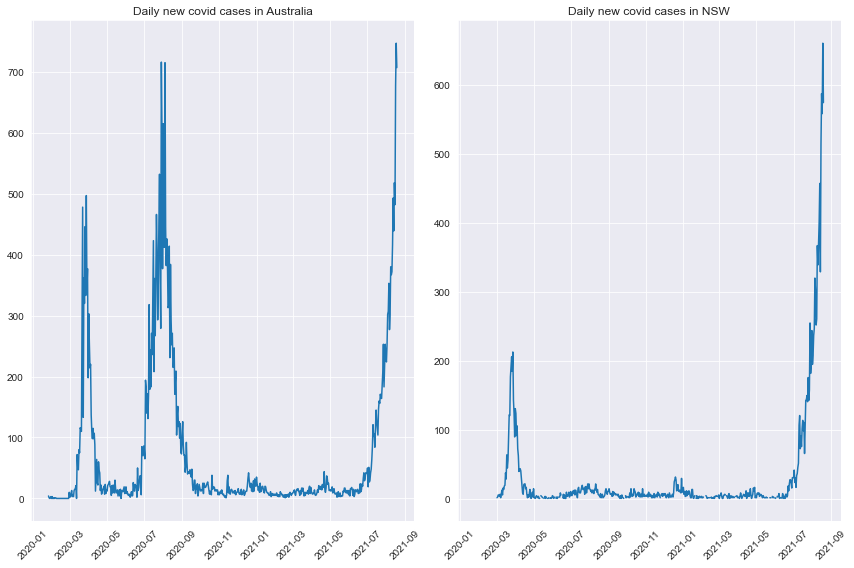

In [7]:
fig,axes = plt.subplots(1,2,figsize=(12,8))
labels = ['2020-01','2020-03','2020-05','2020-07','2020-09','2020-11','2021-01','2021-03','2021-05','2021-07','2021-09']
titles = ['Daily new covid cases in Australia','Daily new covid cases in NSW']

for i,ax in enumerate(axes.flatten()):
    data = merged_df[merged_df.columns[i]]
    ax.plot(data)
    ax.set_xticklabels(labels,rotation=45)
    ax.set_title(titles[i])

plt.tight_layout()    

In [8]:
# check if there is any null value
merged_df.isnull().sum()

aus_new_cases     1
nsw_new_cases    59
dtype: int64

In [9]:
# impute the null values with backwardfill method
merged_df.fillna(method='bfill',inplace=True)

In [10]:
# check if there is any null value remaining
merged_df.isnull().sum()

aus_new_cases    0
nsw_new_cases    0
dtype: int64

In [43]:
# save the cleaned dataframe
import joblib

In [45]:
joblib.dump(merged_df,'daily_case_cleaned_data.csv')

['daily_case_cleaned_data.csv']

## Statistical Tests

In [13]:
# stationarity check

ad_fuller_1 = adfuller(merged_df['aus_new_cases'].diff()[1:])
print("Australia")
print("p-value: {}".format(ad_fuller_1[1]))

ad_fuller_2 = adfuller(merged_df['nsw_new_cases'].diff().diff()[2:])
print("NSW")
print("p-value: {}\n".format(ad_fuller_2[1]))

if ((ad_fuller_1[1] < 0.05) and (ad_fuller_2[1] < 0.05)):
    print("Both the series are stationary")
else:
    print("Atleast one of the series is non-stationary")

Australia
p-value: 0.026434327405406154
NSW
p-value: 3.949036439944995e-14

Both the series are stationary


In [14]:
# correlation check

gran_1 = grangercausalitytests(merged_df[['aus_new_cases','nsw_new_cases']],2)


gran_2 = grangercausalitytests(merged_df[['aus_new_cases','nsw_new_cases']],2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=35.6549 , p=0.0000  , df_denom=569, df_num=1
ssr based chi2 test:   chi2=35.8429 , p=0.0000  , df=1
likelihood ratio test: chi2=34.7647 , p=0.0000  , df=1
parameter F test:         F=35.6549 , p=0.0000  , df_denom=569, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=20.6641 , p=0.0000  , df_denom=566, df_num=2
ssr based chi2 test:   chi2=41.6934 , p=0.0000  , df=2
likelihood ratio test: chi2=40.2414 , p=0.0000  , df=2
parameter F test:         F=20.6641 , p=0.0000  , df_denom=566, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=35.6549 , p=0.0000  , df_denom=569, df_num=1
ssr based chi2 test:   chi2=35.8429 , p=0.0000  , df=1
likelihood ratio test: chi2=34.7647 , p=0.0000  , df=1
parameter F test:         F=35.6549 , p=0.0000  , df_denom=569, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=20.6641 , p=0.0000  

Using Granger causality test we see that the time series are correlated.

## Split the data into train and test parts

In [17]:
train_df = merged_df.iloc[:-30,0:2]
test_df = merged_df.iloc[-30:,0:2]

print(train_df.shape)
print(test_df.shape)

(543, 2)
(30, 2)


In [18]:
train_df.head()

,aus_new_cases,nsw_new_cases
2020-01-25,4.0,3.0
2020-01-26,4.0,1.0
2020-01-27,1.0,1.0
2020-01-28,0.0,2.0
2020-01-29,1.0,2.0


## Build and fit the model

In [19]:
model = VAR(train_df.diff()[1:])

sorted_order = model.select_order()
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        12.24       12.26   2.071e+05       12.25
1        11.88       11.93   1.449e+05       11.90
2        11.64       11.72   1.134e+05       11.67
3        11.58       11.69   1.070e+05       11.62
4        11.59       11.74   1.082e+05       11.65
5        11.53       11.71   1.020e+05       11.60
6        11.48       11.69   9.651e+04       11.56
7        11.43      11.68*   9.227e+04       11.53
8        11.41       11.69   9.011e+04       11.52
9        11.38       11.69   8.764e+04       11.50
10       11.38       11.72   8.759e+04       11.51
11       11.38       11.75   8.736e+04       11.52
12       11.34       11.75   8.412e+04      11.50*
13       11.33       11.77   8.370e+04       11.51
14       11.33       11.80   8.320e+04       11.51
15       11.34       11.85   8.425e+04       11.54
16       11.35       11.89   8.

In [20]:
var_model = VARMAX(train_df,order=(18,0),enforce_stationarity=True)

fitted_model = var_model.fit(disp=False)

In [21]:
n_forecast = 30

start = len(train_df)
end = start + n_forecast

predict = fitted_model.get_prediction(start=start,end=end)

predictions = predict.predicted_mean

predictions.rename(columns={'aus_new_cases':'aus_new_cases_pred',
                            'nsw_new_cases':'nsw_new_cases_pred'},inplace=True)

In [22]:
test_df.index = pd.to_datetime(test_df.index)

true_vs_preds = pd.concat([test_df,predictions.iloc[:-1,:]],axis=1)

## Forecast into the future

### (a) 15 days forecast

In [30]:
# train the model on the entire data

final_var_model = VARMAX(merged_df,order=(18,0),enforce_stationarity=True)

final_fitted_model = final_var_model.fit(disp=False)

# specify the forecast horizon

forecast_len = 15
future_df = pd.DataFrame()
future_df['date'] = np.arange('2021-08-20','2021-09-04',1,dtype='datetime64')
future_df['date'] = future_df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
future_df['date'] =  pd.to_datetime(future_df['date'],format='%Y-%m-%d')
future_df = future_df.set_index('date')

start = len(merged_df)
end = start + forecast_len - 1

# forecast into the future using the trained model
forecast_15 = final_fitted_model.get_prediction(start=start,end=end)

# build a dataframe holding these forecasts
forecast_15_df = forecast_15.predicted_mean[['nsw_new_cases']]

In [31]:
# the forecast dataframe
forecast_15_df

,nsw_new_cases
2021-08-20,558.036391
2021-08-21,610.938848
2021-08-22,572.472202
2021-08-23,620.459811
2021-08-24,620.740173
2021-08-25,614.238283
2021-08-26,473.163689
2021-08-27,555.803078
2021-08-28,583.289639
2021-08-29,586.224014


In [32]:
# save the forecast into an excel format
forecast_15_df.to_excel('nsw_forecst_15.xlsx')

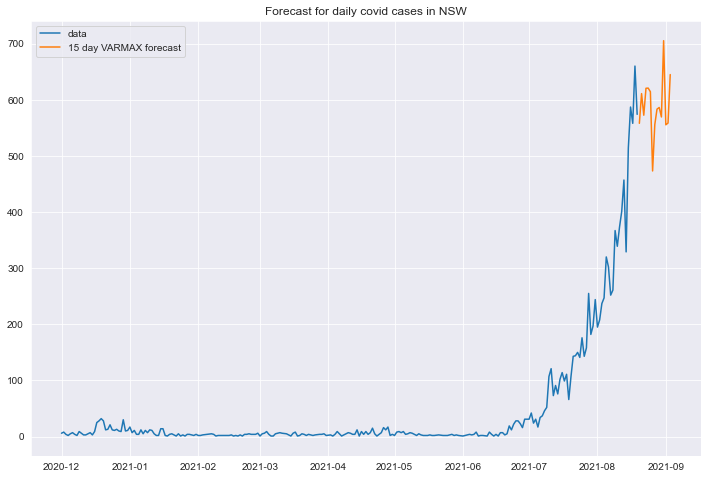

In [38]:
# plot the forecasts
fig_15, ax = plt.subplots(figsize=(12,8))
ax.plot(final_df['nsw_new_cases'].loc['2020-12-01':],label='data') 
ax.plot(forecast_15_df['nsw_new_cases'],label='{} day VARMAX forecast'.format(15))

plt.legend()
plt.title("Forecast for daily covid cases in NSW")
plt.show()

In [40]:
fig_15.savefig('forecast_15.png')

### (b) 30 days forecast

In [34]:
# train the model on the entire data

final_var_model = VARMAX(merged_df,order=(18,0),enforce_stationarity=True)

final_fitted_model = final_var_model.fit(disp=False)

# specify the forecast horizon

forecast_len = 30
future_df = pd.DataFrame()
future_df['date'] = np.arange('2021-08-20','2021-09-19',1,dtype='datetime64')
future_df['date'] = future_df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
future_df['date'] =  pd.to_datetime(future_df['date'],format='%Y-%m-%d')
future_df = future_df.set_index('date')

start = len(merged_df)
end = start + forecast_len - 1

# forecast into the future using the trained models
forecast_30 = final_fitted_model.get_prediction(start=start,end=end)

# build a dataframe holding these forecasts
forecast_30_df = forecast_30.predicted_mean[['nsw_new_cases']]

In [35]:
# the forecast dataframe
forecast_30_df

,nsw_new_cases
2021-08-20,558.036391
2021-08-21,610.938848
2021-08-22,572.472202
2021-08-23,620.459811
2021-08-24,620.740173
2021-08-25,614.238283
2021-08-26,473.163689
2021-08-27,555.803078
2021-08-28,583.289639
2021-08-29,586.224014


In [36]:
# save the forecast into an excel format
forecast_30_df.to_excel('nsw_forecst_30.xlsx')

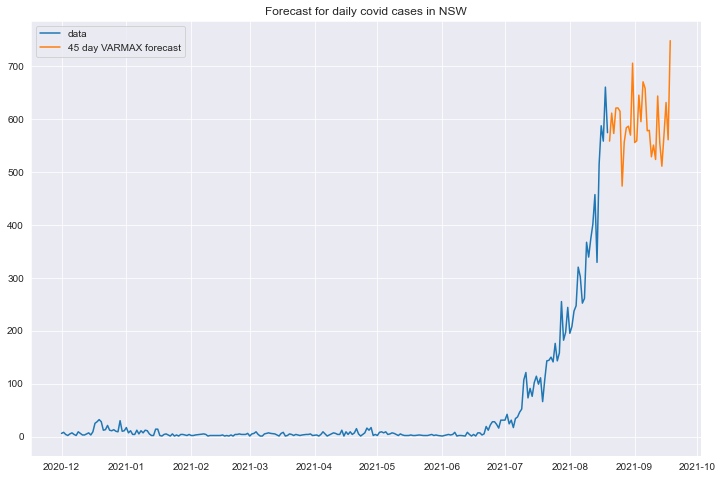

In [41]:
# plot the forecasts
fig_30, ax = plt.subplots(figsize=(12,8))
ax.plot(final_df['nsw_new_cases'].loc['2020-12-01':],label='data') 
ax.plot(forecast_30_df['nsw_new_cases'],label='{} day VARMAX forecast'.format(45))

plt.legend()
plt.title("Forecast for daily covid cases in NSW")
plt.show()

In [42]:
fig_30.savefig('forecast_30.png')